In [1]:
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################

import numpy as np
import pandas as pd

import librosa
import librosa.core
import librosa.feature
import librosa.display
import yaml
import logging
import pathlib
import optuna
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy
import warnings
import ipywidgets as widgets

# from import
from tqdm import tqdm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from ipywidgets import interact, interact_manual

warnings.filterwarnings('ignore')

# Audio examples loading and plot 

In [2]:
normal_example = r'datasets\MIMII_DUE\dev_data\gearbox\source_test\section_00_source_test_normal_0002.wav'
anomal_example = r'datasets\MIMII_DUE\dev_data\gearbox\source_test\section_00_source_test_anomaly_0002.wav'

In [3]:
ipd.Audio(normal_example)

In [4]:
ipd.Audio(anomal_example)

In [5]:
def wav_plot(audio_file, name='wav_plot'):
    x, sr = librosa.load(audio_file, sr=16000, mono=True)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.title(name)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.title(f'{name}_spectrogram')
    plt.colorbar()
    plt.show()

In [6]:
fdir = 'datasets\MIMII_DUE\dev_data\gearbox\source_test/'


@interact
def show_images(file=os.listdir(fdir)):
    wav_plot(fdir+file)

interactive(children=(Dropdown(description='file', options=('section_00_source_test_anomaly_0000.wav', 'sectio…

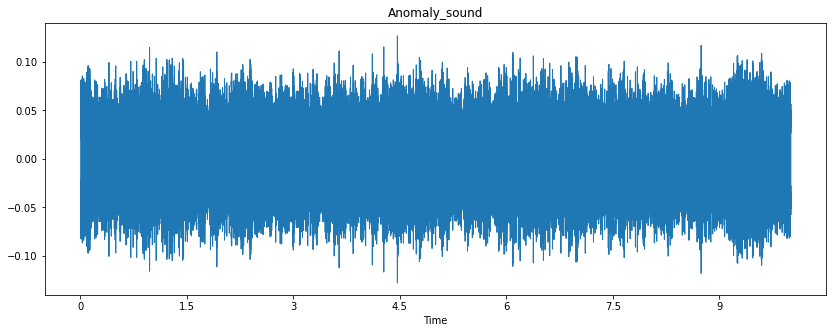

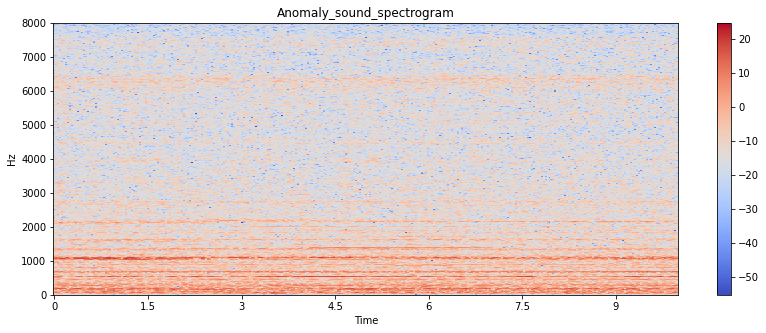

In [7]:
# Anomaly gearbox sound example
wav_plot(anomal_example, 'Anomaly_sound')

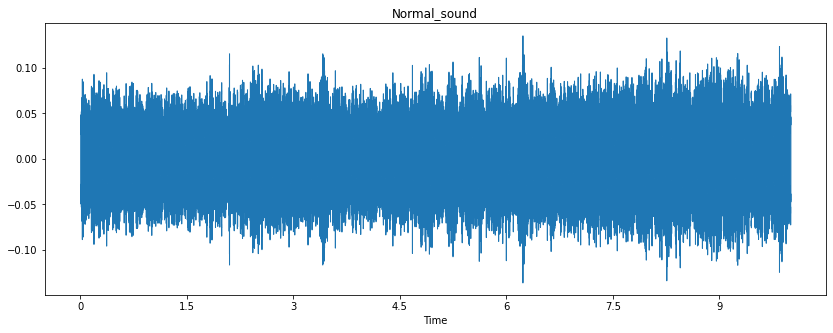

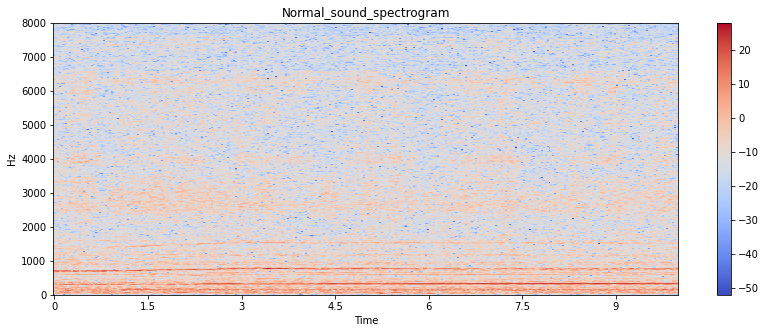

In [8]:
# Normal gearbox sound example
wav_plot(normal_example, 'Normal_sound')

## MFCC Extraction from audio using Librosa

Получение MFCC коэффициентов:
1. сигнал делится на пересекающиеся отрезки по 20-40 мс
2. На этих отрезках применяется оконное реобразование Фурье (STFT)
3. С посмощью применения различных фильтров и преобразований остаются только частоты, ваосринимаемые человеческим ухом 20-20000Гц (Мощность сектра после STFT наносится на mel шкалу с помощью теругольных или косинусных перекрывающих окон) 
4. В итоге MFCC - это амплитуды результирующего спектра


In [9]:
def plot_MFFC_from_audio(file_name, n_mfcc):
    x, sr = file_load(file_name, mono=True)
    mfccs = librosa.feature.mfcc(x, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(7, 4))
    plt.title('MFCC')
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [10]:
fdir = 'datasets\MIMII_DUE\dev_data\gearbox\source_test/'
# Interact with specification of arguments


@interact
def show_articles_more_than(file=os.listdir(fdir), x=(2, 100)):
    return plot_MFFC_from_audio(fdir+file, x)

interactive(children=(Dropdown(description='file', options=('section_00_source_test_anomaly_0000.wav', 'sectio…

# Dataset creation

In [11]:
!ffmpeg - i datasets\MIMII_DUE\dev_data\gearbox\source_test\section_00_source_test_normal_0000.wav

ffmpeg version 2022-07-21-git-f7d510b33f-essentials_build-www.gyan.dev Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12.1.0 (Rev2, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-

In [12]:
"""
Standard output is logged in "baseline.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="baseline.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [13]:
# train data
target_dir_train = r'datasets\MIMII_DUE\dev_data\gearbox'
section_name = 'section_00'
dir_name_train = r'\train'
mode = 'development'

# source_test data
target_dir_source_test = r'datasets\MIMII_DUE\dev_data\gearbox'
dir_name_source_test = r'\source_test'

# target_test data
target_dir_target_test = r'datasets\MIMII_DUE\dev_data\gearbox'
dir_name_target_test = r'\target_test'

In [14]:
########################################################################
# all files from directory/section in file list and labels from audio file description
########################################################################
def file_list_generator(target_dir,
                        section_name,
                        dir_name,
                        mode,
                        prefix_normal="normal",
                        prefix_anomaly="anomaly",
                        ext="wav"):
    """
    target_dir : str
        base directory path
    section_name : str
        section name of audio file in <<dir_name>> directory
    dir_name : str
        sub directory name
    prefix_normal : str (default="normal")
        normal directory name
    prefix_anomaly : str (default="anomaly")
        anomaly directory name
    ext : str (default="wav")
        file extension of audio files
    return :
        if the mode is "development":
            files : list [ str ]
                audio file list
            labels : list [ boolean ]
                label info. list
                * normal/anomaly = 0/1
        if the mode is "evaluation":
            files : list [ str ]
                audio file list
    """
    logger.info("target_dir : {}".format(target_dir + "_" + section_name))

    # development
    if mode:
        query = os.path.abspath("{target_dir}/{dir_name}/{section_name}_*_{prefix_normal}_*.{ext}".format(target_dir=target_dir,
                                                                                                          dir_name=dir_name,
                                                                                                          section_name=section_name,
                                                                                                          prefix_normal=prefix_normal,
                                                                                                          ext=ext))
        normal_files = sorted(glob.glob(query))
        normal_labels = np.zeros(len(normal_files))

        query = os.path.abspath("{target_dir}/{dir_name}/{section_name}_*_{prefix_normal}_*.{ext}".format(target_dir=target_dir,
                                                                                                          dir_name=dir_name,
                                                                                                          section_name=section_name,
                                                                                                          prefix_normal=prefix_anomaly,
                                                                                                          ext=ext))
        anomaly_files = sorted(glob.glob(query))
        anomaly_labels = np.ones(len(anomaly_files))

        files = np.concatenate((normal_files, anomaly_files), axis=0)
        labels = np.concatenate((normal_labels, anomaly_labels), axis=0)

        logger.info("#files : {num}".format(num=len(files)))
        if len(files) == 0:
            logger.exception("no_wav_file!!")
        print("\n========================================")

    # evaluation
    else:
        query = os.path.abspath("{target_dir}/{dir_name}/{section_name}_*.{ext}".format(target_dir=target_dir,
                                                                                        dir_name=dir_name,
                                                                                        section_name=section_name,
                                                                                        ext=ext))
        files = sorted(glob.glob(query))
        labels = None
        logger.info("#files : {num}".format(num=len(files)))
        if len(files) == 0:
            logger.exception("no_wav_file!!")
        print("\n=========================================")

    return files, labels

In [15]:
########################################################################
# feature extractor
########################################################################
def feature_extraction_from_file(file_name):
    """
    feature extraction for each file

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * feature.shape = (1, feature_vector_length)
    """
    y, sr = librosa.load(file_name, sr=16000, mono=True)

    # Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # MFCCs statistics
    mfccs_mean = np.mean(mfccs.T, axis=0)
    mfccs_std = np.mean(mfccs.T, axis=0)
    mfccs_max = np.mean(mfccs.T, axis=0)
    mfccs_min = np.mean(mfccs.T, axis=0)

    # spectral centroid and statistic
    # Спектральный центроид указывает, на какой частоте сосредоточена энергия спектра (энергия напряжения)
    # т.е указывает, где расположен “центр масс” для звука.
    cent_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                        axis=0)[0]
    cent_std = np.std(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                      axis=0)[0]
    cent_max = np.max(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                      axis=0)[0]
    cent_min = np.min(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                      axis=0)[0]

    features = np.concatenate((
        mfccs_mean, mfccs_std, mfccs_max, mfccs_min), axis=0)

    cent_skew = scipy.stats.skew(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                                 axis=0)[0]

    # center frequency for a spectrogram bin such that at least roll_percent (0.85 by default)
    # of the energy of the spectrum in this frame is contained in this bin and the bins below
    rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T,
                           axis=0)[0]
    rolloff_std = np.std(librosa.feature.spectral_rolloff(y=y, sr=sr).T,
                         axis=0)[0]
    rolloff_max = np.max(librosa.feature.spectral_rolloff(y=y, sr=sr).T,
                         axis=0)[0]
    rolloff_min = np.min(librosa.feature.spectral_rolloff(y=y, sr=sr).T,
                         axis=0)[0]

    features = np.concatenate((mfccs_mean, mfccs_std, mfccs_max, mfccs_min, np.array(
        (cent_skew, rolloff_mean, rolloff_std, rolloff_max, rolloff_min))), axis=0)
    
    return features.reshape(1, -1)

In [16]:
########################################################################
# all dataset from file_list with features
########################################################################
def file_list_to_data(file_list):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.
    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.
    return : numpy.array( numpy.array( float ) )
        data for training (this function is not used for test.)
        * dataset.shape = (number of feature vectors, dimensions of feature vectors)
    """

    # iterate file_to_vector_array()
    for idx in tqdm(range(len(file_list))):
        vectors = feature_extraction_from_file(file_list[idx])
        if idx == 0:
            data = np.zeros(
                (len(file_list) * vectors.shape[0], vectors.shape[1]), float)
        data[vectors.shape[0] * idx: vectors.shape[0] * (idx + 1), :] = vectors

    return data

In [17]:
f_list_train, y_train = file_list_generator(target_dir_train,
                                            section_name,
                                            dir_name_train,
                                            mode,
                                            prefix_normal="normal",
                                            prefix_anomaly="anomaly",
                                            ext="wav")

f_list_source_test, y_source_test = file_list_generator(target_dir_source_test,
                                                        section_name,
                                                        dir_name_source_test,
                                                        mode,
                                                        prefix_normal="normal",
                                                        prefix_anomaly="anomaly",
                                                        ext="wav")

f_list_target_test, y_target_test = file_list_generator(target_dir_target_test,
                                                        section_name,
                                                        dir_name_target_test,
                                                        mode,
                                                        prefix_normal="normal",
                                                        prefix_anomaly="anomaly",
                                                        ext="wav")

2022-09-08 00:10:27,548 - INFO - target_dir : datasets\MIMII_DUE\dev_data\gearbox_section_00
2022-09-08 00:10:27,575 - INFO - #files : 1004
2022-09-08 00:10:27,576 - INFO - target_dir : datasets\MIMII_DUE\dev_data\gearbox_section_00
2022-09-08 00:10:27,582 - INFO - #files : 300
2022-09-08 00:10:27,583 - INFO - target_dir : datasets\MIMII_DUE\dev_data\gearbox_section_00
2022-09-08 00:10:27,588 - INFO - #files : 204


In [18]:
len(f_list_train), len(f_list_source_test), len(f_list_target_test)

(1004, 300, 204)

In [19]:
X_train = file_list_to_data(f_list_train)

X_source_test = file_list_to_data(f_list_source_test)

X_target_test = file_list_to_data(f_list_target_test)

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:29<00:00,  6.90it/s]


In [20]:
X_train.shape, X_source_test.shape, X_target_test.shape

((1004, 165), (300, 165), (204, 165))

# PyOD models comparison

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_source_test = scaler.transform(X_source_test)
X_target_test = scaler.transform(X_target_test)

In [22]:
def anomaly_detection(model_name, X_train, X_test, y_train, y_test):

    clf = models[model_name]
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    r = metrics.precision_score(y_test, y_test_pred)
    f = metrics.f1_score(y_test, y_test_pred)
    a = metrics.accuracy_score(y_test, y_test_pred)
    report = metrics.classification_report(y_test, y_test_pred)
    print(f'On Test Data:')
    evaluate_print(model_name, y_test, y_test_scores)
    print(f'\n{report} \n')
    
    if model_name == 'IForest':
        # example of the feature importance
        feature_importance = clf.feature_importances_
        # print("Feature importance", feature_importance)
    else:
        feature_importance =''
        
    return y_test_scores

In [23]:
models = {'IForest': IForest(behaviour='old',
                             bootstrap=False,
                             contamination=0.5,
                             max_features=1.0,
                             max_samples='auto',
                             n_estimators=1000,
                             n_jobs=1,
                             random_state=0,
                             verbose=0),
          'LOF': LOF(),
          'KNN': KNN()}

for model_name, model in models.items():
    score = anomaly_detection(model_name, X_train, X_target_test,
                          y_train, y_target_test)

On Test Data:
IForest ROC:0.6683, precision @ rank n:0.6204

              precision    recall  f1-score   support

         0.0       0.58      0.55      0.56        96
         1.0       0.62      0.64      0.63       108

    accuracy                           0.60       204
   macro avg       0.60      0.60      0.60       204
weighted avg       0.60      0.60      0.60       204
 

On Test Data:
LOF ROC:0.7114, precision @ rank n:0.6852

              precision    recall  f1-score   support

         0.0       0.58      0.93      0.71        96
         1.0       0.86      0.40      0.54       108

    accuracy                           0.65       204
   macro avg       0.72      0.66      0.63       204
weighted avg       0.73      0.65      0.62       204
 

On Test Data:
KNN ROC:0.7066, precision @ rank n:0.6389

              precision    recall  f1-score   support

         0.0       0.51      0.92      0.66        96
         1.0       0.75      0.22      0.34       108

   

# Hyperparameter optimization

In [29]:
def run_SAD(trial):
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 2, 40),
    }

    model = KNN(**param)
    model.fit(X_train)

    preds = model.predict(X_target_test)
    score = metrics.accuracy_score(y_target_test, preds)
    return score

In [30]:
sad_study = optuna.create_study(direction="maximize")
sad_study.optimize(run_SAD, n_trials=100, timeout=60)

[I 2022-09-08 00:15:35,912] A new study created in memory with name: no-name-d8ea8856-c391-44cd-8388-4e7ef6e9e327
[I 2022-09-08 00:15:35,983] Trial 0 finished with value: 0.5490196078431373 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 0.5490196078431373.
[I 2022-09-08 00:15:36,061] Trial 1 finished with value: 0.5294117647058824 and parameters: {'n_neighbors': 34}. Best is trial 0 with value: 0.5490196078431373.
[I 2022-09-08 00:15:36,139] Trial 2 finished with value: 0.5196078431372549 and parameters: {'n_neighbors': 40}. Best is trial 0 with value: 0.5490196078431373.
[I 2022-09-08 00:15:36,212] Trial 3 finished with value: 0.5343137254901961 and parameters: {'n_neighbors': 9}. Best is trial 0 with value: 0.5490196078431373.
[I 2022-09-08 00:15:36,288] Trial 4 finished with value: 0.5147058823529411 and parameters: {'n_neighbors': 19}. Best is trial 0 with value: 0.5490196078431373.
[I 2022-09-08 00:15:36,363] Trial 5 finished with value: 0.5490196078431373 and par

[I 2022-09-08 00:15:39,737] Trial 47 finished with value: 0.5343137254901961 and parameters: {'n_neighbors': 35}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:39,814] Trial 48 finished with value: 0.5392156862745098 and parameters: {'n_neighbors': 7}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:39,893] Trial 49 finished with value: 0.5343137254901961 and parameters: {'n_neighbors': 9}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:39,971] Trial 50 finished with value: 0.5588235294117647 and parameters: {'n_neighbors': 6}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:40,048] Trial 51 finished with value: 0.5637254901960784 and parameters: {'n_neighbors': 4}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:40,127] Trial 52 finished with value: 0.5637254901960784 and parameters: {'n_neighbors': 4}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:40,207]

[I 2022-09-08 00:15:43,404] Trial 94 finished with value: 0.5637254901960784 and parameters: {'n_neighbors': 2}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:43,481] Trial 95 finished with value: 0.5637254901960784 and parameters: {'n_neighbors': 2}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:43,557] Trial 96 finished with value: 0.5588235294117647 and parameters: {'n_neighbors': 6}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:43,634] Trial 97 finished with value: 0.5637254901960784 and parameters: {'n_neighbors': 4}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:43,711] Trial 98 finished with value: 0.5392156862745098 and parameters: {'n_neighbors': 7}. Best is trial 11 with value: 0.5637254901960784.
[I 2022-09-08 00:15:43,791] Trial 99 finished with value: 0.5343137254901961 and parameters: {'n_neighbors': 9}. Best is trial 11 with value: 0.5637254901960784.


In [31]:
print("Number of finished trials: {}".format(len(sad_study.trials)))

print("Best trial:")
trial = sad_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.5637254901960784
  Params: 
    n_neighbors: 2
